# Проект: Создание модели машинного обучения для предсказания состояния работы крутильного вала в режиме реального времени.

**Описание проекта**: Проект посвящен разработке системы предсказания состояния крутильного вала турбоагрегата в режиме реального времени на основе методов машинного обучения. Объектом исследования являются исторические данные работы турбины за 2016 год, включающие параметры давления, температуры и частоты с интервалом 1 час.

**Цель проекта**: Целью проекта является создание модели машинного обучения для прогнозирования критических состояний крутильного вала турбоагрегата в режиме реального времени и разработка архитектуры предиктивной системы, обеспечивающей: 
- Сбор и предобработку данных с датчиков турбины.
- Обучение и переобучение модели с учетом актуальных данных.
- Прогнозирование ключевых параметров работы турбины и выявление отклонений.
- Визуализацию результатов и мониторинг состояния турбины для предотвращения аварийных ситуаций.

План:

1) Заняться генерацией признаков:
- 1.1) Признаки, которые сигнализируют простой/его близость и тд.
- 1.2) Обработка пропусков и заполнение малых пропусков интерполяцией
- 1.3) Временные и лаговые признаки
- 1.4) Полиномиальные признаки и признаки разности лагов
- 1.5) Признаки преобразования и различные статистики

2) Часть с тренировкой модели:
- 2.1) Написать пайплайн с тюнингом гиперпараметров модели в зависимости от количества моделей/типа фич, которые были выбраны.
- 2.2) Написать пайплайн по permutation importance для отбора фич

Лучшие метрики модели SARIMAX, полученные коллегой на этом же датасете:
- MAE: 0.032853528555852385
- MSE: 0.0012413360200539234
- RMSE: 0.035232598826284774
- MAPE: 0.1701346412714233%

Для начала импортируем все инструменты и библиотеки, которые нам понадобятся по ходу проекта:

In [17]:
from copy import deepcopy

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MultipleLocator
from scipy.fft import fft, fftfreq
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
)


from features import make_features, prepare_data
from utils import plot_result, set_seed, reduce_mem_usage, get_nan_intervals
from training import tuning_pipeline, make_permutation_and_feature_importance


set_seed(42)

In [18]:
data = pd.read_excel('Prism_МоДеРо.xlsx', skiprows=3, usecols='I:Z')
data = data.rename(columns={'Код сигнала': 'Date'})

Окинем взглядом данные

In [19]:
data.head()

,Date,F1,Pa,Pr,Td,Tg,Tst,Тп. ЦНД-1\n,Тп.ЦНД-2\n,Т ГПЗ н.А,Т ГПЗ н.Б,Т ГПЗ н.В,Т ГПЗ н.Г,Т турб. н.А,Т турб.н.Б,Т турб.н.В,Т турб.н.Г,Fr
0,2016-01-01 00:00:00,19.282400,134.753082,-90.211281,37.487492,31.800579,45.405594,9.033,12.256,539.282,540.747,541.553,545.215,548.950,548.657,545.288,545.801,49.995281
1,2016-01-01 01:00:00,19.283903,134.220016,-86.393089,37.478737,31.870878,45.505035,8.936,12.256,539.209,540.234,541.553,544.482,550.562,549.683,545.874,546.826,50.005314
2,2016-01-01 02:00:00,19.282400,134.415543,-83.297874,37.238052,31.816473,45.399033,9.033,12.280,541.992,541.992,541.333,545.581,553.491,552.246,549.170,549.243,50.002312
3,2016-01-01 03:00:00,19.286156,134.487137,-90.895683,37.348053,31.711052,45.473736,9.082,12.256,539.868,540.747,541.699,543.970,552.612,551.733,548.364,548.438,50.001530
4,2016-01-01 04:00:00,19.283903,132.702866,-95.911263,37.513912,31.732071,45.622948,9.082,12.256,537.964,538.989,540.454,542.432,552.979,551.440,548.804,549.023,50.022942


Окинем быстрым взглядом подгруженные данные через метод *info*:

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6679 non-null   datetime64[ns]
 1   F1           6679 non-null   float64       
 2   Pa           6679 non-null   float64       
 3   Pr           6679 non-null   float64       
 4   Td           6679 non-null   float64       
 5   Tg           6679 non-null   float64       
 6   Tst          6679 non-null   float64       
 7   Тп. ЦНД-1
   6679 non-null   float64       
 8   Тп.ЦНД-2
    6679 non-null   float64       
 9   Т ГПЗ н.А    6679 non-null   float64       
 10  Т ГПЗ н.Б    6679 non-null   float64       
 11  Т ГПЗ н.В    6679 non-null   float64       
 12  Т ГПЗ н.Г    6679 non-null   float64       
 13  Т турб. н.А  6679 non-null   float64       
 14  Т турб.н.Б   6679 non-null   float64       
 15  Т турб.н.В   6679 non-null   float64       
 16  Т турб

Посмотрим на то, как выглядит исходный временной ряд

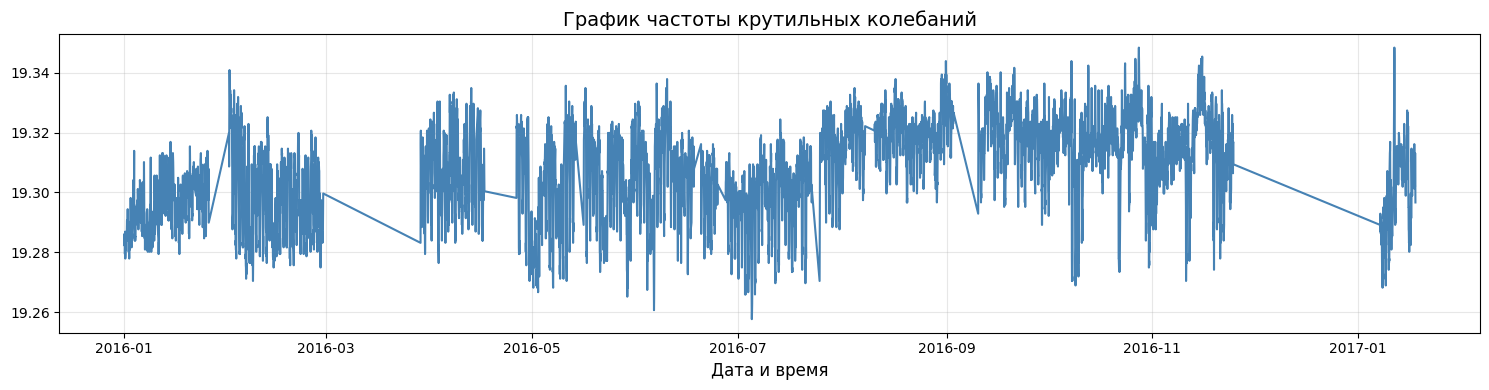

In [21]:
plt.figure(figsize=(15, 4))

plt.plot(
    data['Date'],
    data['F1'],
    linewidth=1.5,
    color='steelblue',
    label='Частота крутильных колебаний'
)

plt.xlabel('Дата и время', fontsize=12)
plt.title('График частоты крутильных колебаний', fontsize=14)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### EDA

Посмотрим сколько пропусков в нашем ряду

In [22]:
# суммарно 2516 nan, все по датам совпадают, то есть в этих точка пропуски по всем столбцам
df = data.copy()
df = df.set_index('Date').resample('h').mean()
for i in df.columns.tolist():
    print(df[df[i].isna()].shape)

(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)
(2516, 17)


Выделим пропуски

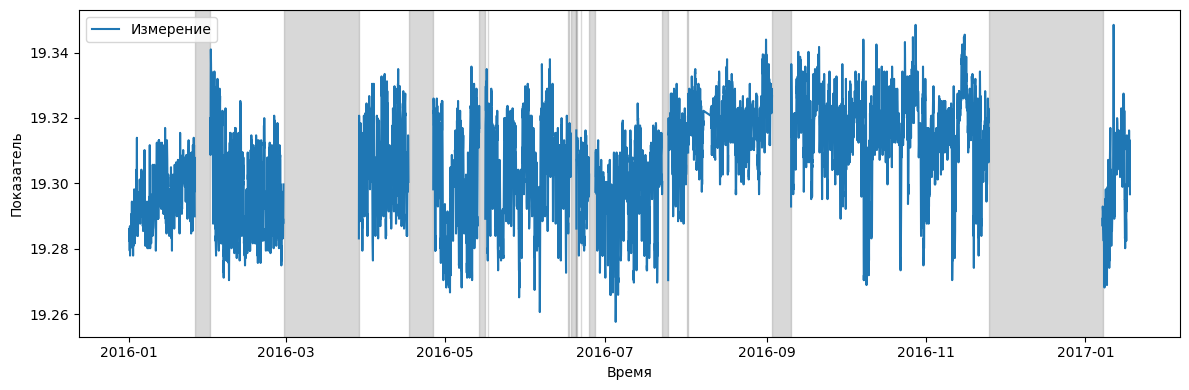

In [23]:
mask = df['F1'].isna()

changes = mask.astype(int).diff().fillna(0)

starts = df.index[changes ==  1]
ends  = df.index[changes == -1]

if mask.iloc[0]:
    starts = starts.insert(0, df.index[0])
if mask.iloc[-1]:
    ends = ends.append(pd.Index([df.index[-1]]))

intervals = list(zip(starts, ends))

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df['F1'], label='Измерение')

for t0, t1 in intervals:
    ax.axvspan(t0, t1, color='grey', alpha=0.3)

ax.set_xlabel('Время')
ax.set_ylabel('Показатель')
ax.legend()
plt.tight_layout()
plt.show()

В последствии, в пайплане предобработки данных эти пропуски необходимо удалить и/или интерполировать средним значением

# Матрица корреляции

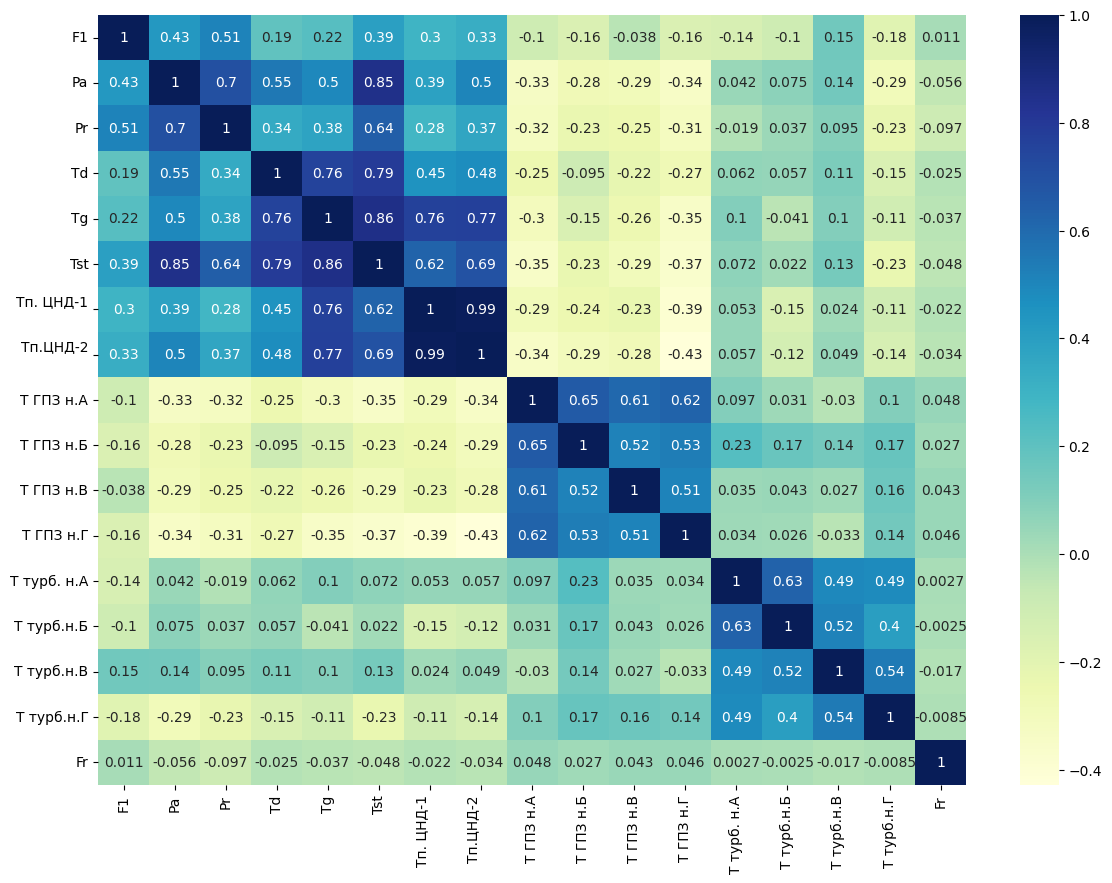

In [24]:
co_mtx = df[df.F1 != 0].corr(numeric_only=True)

f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(co_mtx, cmap="YlGnBu", annot=True)

plt.show()

**Промежуточные выводы:**

Видна корреляция между признаками, между которыми её и так можно было бы предположить: 
- Температурные признаки ЦНД очень сильно коррелируют друг с другом
- Давление кореллирует с температурой

Не думаю, что какие-либо из этих признаков можно удалить, так мы можем лишиться важных данных, на которые, в последствие, не сможет опираться дерево решений.

# Посмотрим на распределение таргета

<Axes: xlabel='F1', ylabel='Count'>

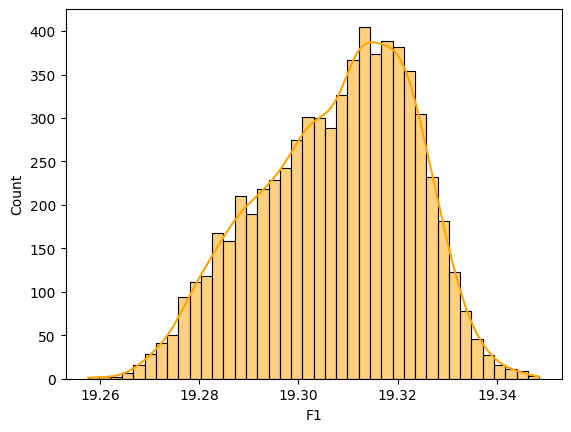

In [25]:
sns.histplot(df["F1"], kde=True, color="orange", bins=40)

# Построим boxplot таргета по месяцам

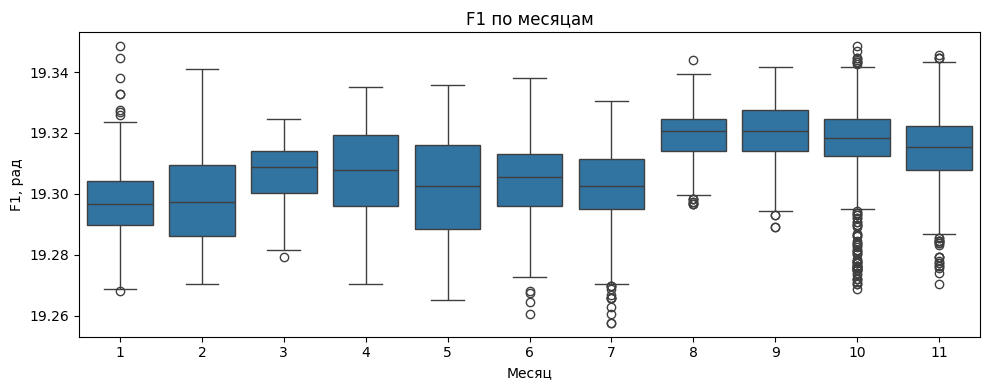

In [26]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[df["F1"] > 0].index.month, y=df[df["F1"] > 0]['F1'])
plt.xlabel("Месяц"); plt.ylabel("F1, рад"); plt.title("F1 по месяцам")
plt.tight_layout(); plt.show()

# Рассмотрим амплитудный спектр сигнала F1, чтобы выявить доминирующие частоты и соответствующие им периоды, характеризующие основные циклы в данных.

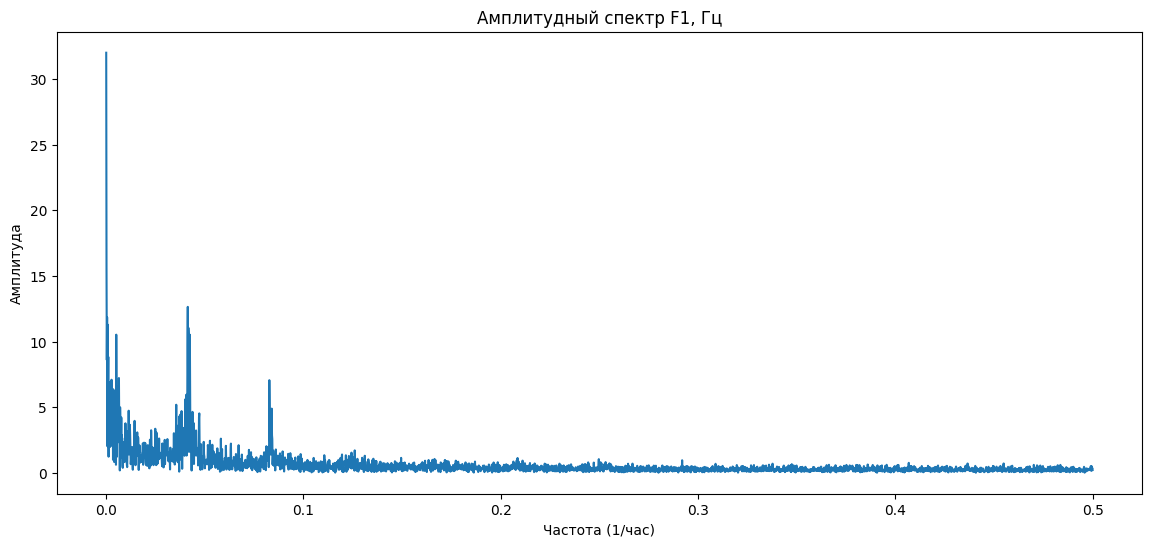

Доминирующие частоты: [0.00089834 0.00059889 0.04147327 0.00029945 0.00014972]
Соответствующие периоды (часов): [1113.16666667 1669.75         24.11191336 3339.5        6679.        ]


In [27]:
y = data['F1'].values
n = len(y)
dt = 1  

yf = fft(y - np.mean(y)) 
xf = fftfreq(n, dt)

mask = xf > 0
xf = xf[mask]
yf = np.abs(yf[mask])

plt.figure(figsize=(14,6))
plt.plot(xf, yf)
plt.title("Амплитудный спектр F1, Гц")
plt.xlabel("Частота (1/час)")
plt.ylabel("Амплитуда")
plt.show()

peak_idx = np.argsort(yf)[-5:]
dominant_freqs = xf[peak_idx]
dominant_periods = 1 / dominant_freqs  
print("Доминирующие частоты:", dominant_freqs)
print("Соответствующие периоды (часов):", dominant_periods)


Видим, что в часах фигурирует значение 24 (сутки). Разложим по этому значению ряд на тренд и сезонность

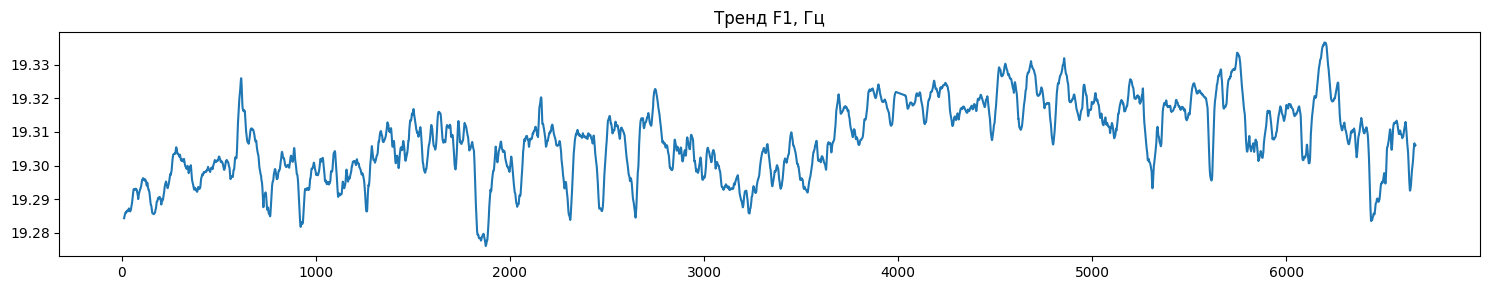

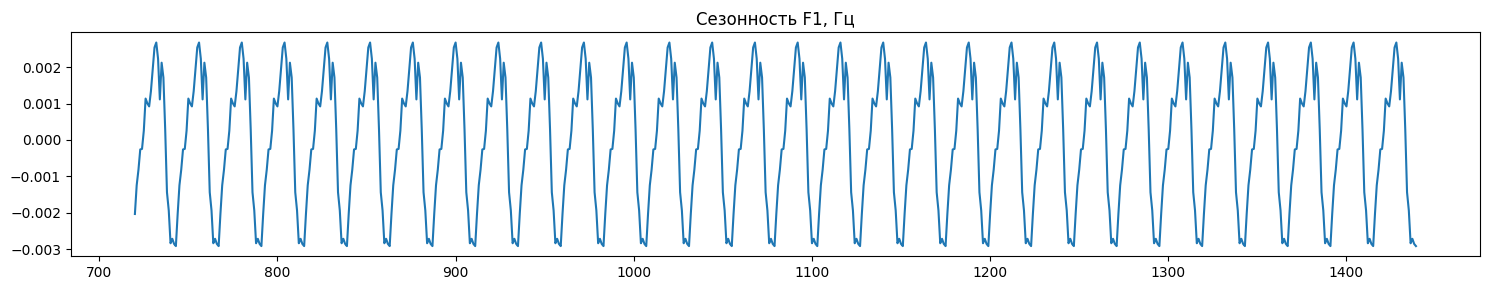

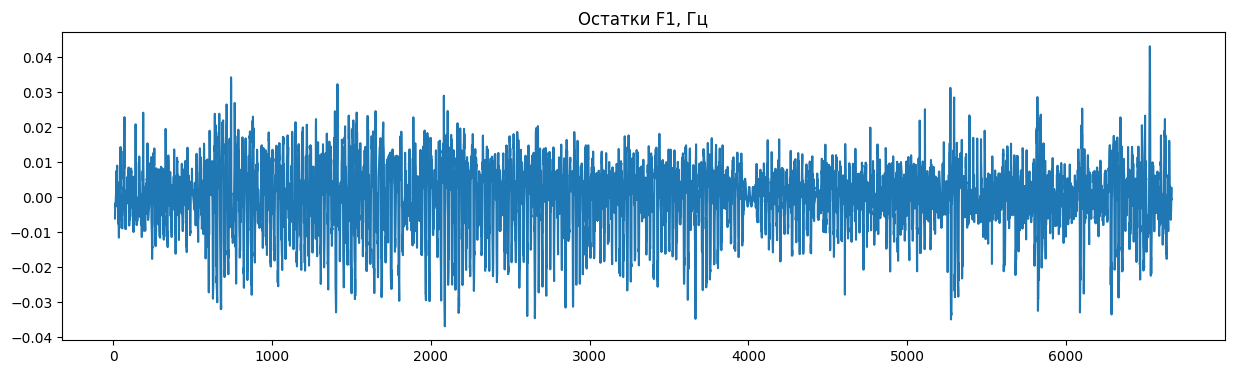

In [28]:
decomposed = seasonal_decompose(data['F1'], period=24)

plt.figure(figsize=(15,3))
plt.plot(decomposed.trend)
plt.title("Тренд F1, Гц")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plt.plot(decomposed.seasonal.iloc[24*30 : 24*60])
plt.title("Сезонность F1, Гц")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,4))
plt.plot(decomposed.resid)
plt.title("Остатки F1, Гц")
plt.show()

Видим, что какого-то заметного тренда в ряде не наблюдается. При этом замента дневная сезонность

# Исследуем ряд на авто и на частичную корелляцию:

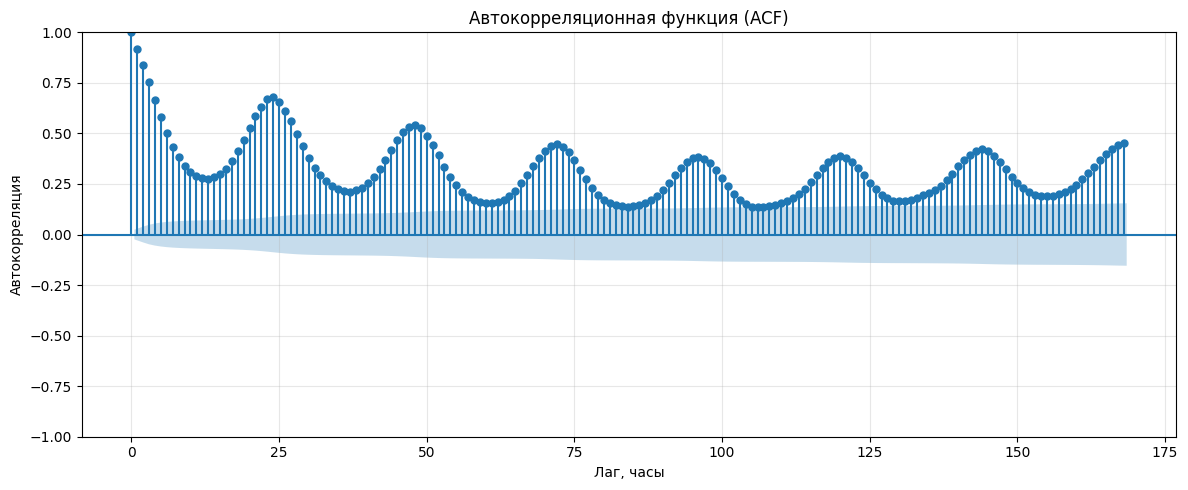

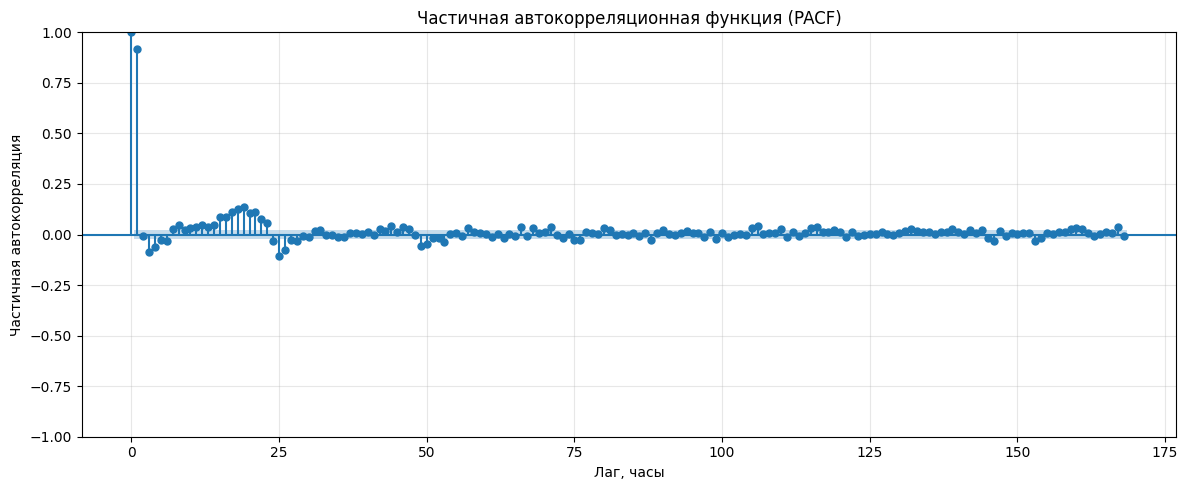

In [29]:
# Целевой временной ряд
series = data['F1'].dropna()

# ---------- ACF ----------
plt.figure(figsize=(12, 5))
plot_acf(
    series,
    lags=168,          # до недели при часовой дискретизации
    ax=plt.gca()
)
plt.title("Автокорреляционная функция (ACF)")
plt.xlabel("Лаг, часы")
plt.ylabel("Автокорреляция")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- PACF ----------
plt.figure(figsize=(12, 5))
plot_pacf(
    series,
    lags=168,
    method='ywm',      # устойчивый метод
    ax=plt.gca()
)
plt.title("Частичная автокорреляционная функция (PACF)")
plt.xlabel("Лаг, часы")
plt.ylabel("Частичная автокорреляция")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- График автокорреляционной функции демонстрирует выраженные пики, повторяющиеся с периодом 24 часа, с постепенным затуханием амплитуды по мере увеличения лага. Такое поведение характерно для временных рядов с ярко выраженной суточной сезонностью и подтверждает наличие регулярных циклических колебаний в данных. 
- На графике частичной автокорреляции в пределах одной недели наибольшее значение наблюдается на первом лаге, что указывает на сильную зависимость текущего значения показателя от значения на предыдущем временном шаге.

### Генерация признаков

Для формирования расширенного набора признаков используется функция генерации признаков, реализованная в модуле `features` (временные метки, лаги, скользящие статистики по окнам, полиномиальные признаки, экспоненциальное сглаживание, разности лагов).


In [30]:
df = prepare_data(data)
df_copy = deepcopy(df)

In [31]:
df

,Date,y,is_run,hour_off,hour_on,month_sin,month_cos,day_of_month_sin,day_of_month_cos,day_of_week_sin,...,delta_lag_9lag_82,delta_lag_9lag_8_delta_lag_10lag_9,delta_lag_9lag_8_delta_lag_11lag_10,delta_lag_9lag_8_delta_lag_12lag_11,delta_lag_10lag_92,delta_lag_10lag_9_delta_lag_11lag_10,delta_lag_10lag_9_delta_lag_12lag_11,delta_lag_11lag_102,delta_lag_11lag_10_delta_lag_12lag_11,delta_lag_12lag_112
0,2016-01-08 00:00:00,19.284653,1,0,169,0.5,0.866025,0.994522,-0.104528,-0.433884,...,5.625000e-07,-0.000002,5.640000e-07,2.253000e-06,5.076009e-06,-0.000002,-6.768012e-06,5.655040e-07,0.000002,9.024016e-06
1,2016-01-08 01:00:00,19.280148,1,0,170,0.5,0.866025,0.994522,-0.104528,-0.433884,...,9.024016e-06,0.000002,-6.768012e-06,2.259008e-06,5.625000e-07,-0.000002,5.640000e-07,5.076009e-06,-0.000002,5.655040e-07
2,2016-01-08 02:00:00,19.283152,1,0,171,0.5,0.866025,0.994522,-0.104528,-0.433884,...,1.443843e-04,-0.000036,-9.012000e-06,2.707205e-05,9.024016e-06,0.000002,-6.768012e-06,5.625000e-07,-0.000002,5.076009e-06
3,2016-01-08 03:00:00,19.286907,1,0,172,0.5,0.866025,0.994522,-0.104528,-0.433884,...,5.655040e-07,0.000009,-2.259008e-06,-5.640000e-07,1.443843e-04,-0.000036,-9.012000e-06,9.024016e-06,0.000002,5.625000e-07
4,2016-01-08 04:00:00,19.285404,1,0,173,0.5,0.866025,0.994522,-0.104528,-0.433884,...,1.105652e-04,-0.000008,-1.263482e-04,3.158706e-05,5.655040e-07,0.000009,-2.259008e-06,1.443843e-04,-0.000036,9.024016e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6506,2017-01-17 22:00:00,19.304180,1,0,6675,0.5,0.866025,-0.406737,-0.913545,0.781831,...,2.253001e-06,-0.000002,-0.000000e+00,5.636255e-06,2.253001e-06,0.000000,-5.636255e-06,0.000000e+00,-0.000000,1.410002e-05
6507,2017-01-17 23:00:00,19.301928,1,0,6676,0.5,0.866025,-0.406737,-0.913545,0.781831,...,4.569760e-05,0.000010,-1.014676e-05,-0.000000e+00,2.253001e-06,-0.000002,-0.000000e+00,2.253001e-06,0.000000,0.000000e+00
6508,2017-01-18 00:00:00,19.313192,1,0,6677,0.5,0.866025,-0.587785,-0.809017,0.974928,...,1.410754e-05,-0.000025,-5.637756e-06,5.637756e-06,4.569760e-05,0.000010,-1.014676e-05,2.253001e-06,-0.000002,2.253001e-06
6509,2017-01-18 01:00:00,19.303429,1,0,6678,0.5,0.866025,-0.587785,-0.809017,0.974928,...,0.000000e+00,0.000000,-0.000000e+00,-0.000000e+00,1.410754e-05,-0.000025,-5.637756e-06,4.569760e-05,0.000010,2.253001e-06


In [32]:
preds, val_mape, test_mape, best_model_config, test = tuning_pipeline(df.drop(columns=['Date']))
print('F1')
plot_result(test.drop(columns=['y']), test['y'].values, preds[24 * 7:])

results = make_permutation_and_feature_importance(
    df.drop(columns=['Date']), best_model_config
)
best_model = results['filtered_model']
features = results['features']
joblib.dump(best_model, f'service/models/LGBMModel_F1.pkl')
artifacts = pd.DataFrame([
    {'best_model_config': best_model_config, 'features': features}
], index=[0])
artifacts.to_csv(f'service/artifacts/F1.csv', index=False)

  0%|          | 0/75 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's mape: 0.000236192	valid_0's l2: 3.68123e-05
Trial: 0.00023619108834982283
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2497]	valid_0's mape: 0.000236121	valid_0's l2: 3.66052e-05
Trial: 0.00023612021519068253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[447]	valid_0's mape: 0.0002356	valid_0's l2: 3.69253e-05
Trial: 0.00023559982399121735
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's mape: 0.000235418	valid_0's l2: 3.68426e-05
Trial: 0.00023541664609371616
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's mape: 0.000230963	valid_0's l2: 3.70943e-05
Trial: 0.00023096234116548906
Training until validation scores don't improv

C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.0311805843889876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2334]	valid_0's mape: 0.000239576	valid_0's l2: 3.79031e-05
Trial: 0.0002395745017742245


C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.0144453565158442
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[787]	valid_0's mape: 0.000233197	valid_0's l2: 3.59534e-05
Trial: 0.00023319601000024013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's mape: 0.000229688	valid_0's l2: 3.52589e-05
Trial: 0.0002296870673847308
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	valid_0's mape: 0.000230296	valid_0's l2: 3.89171e-05
Trial: 0.00023029597788043376
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[90]	valid_0's mape: 0.000229376	valid_0's l2: 3.53151e-05
Trial: 0.00022937524621484976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's mape: 0.000236022	valid_0's l2: 3.64376e-05
Trial: 0.00023602138011878548
Training until validation scores don't improve fo

C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.011247367029564
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1584]	valid_0's mape: 0.000225328	valid_0's l2: 3.49368e-05
Trial: 0.00022532754987930923
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1613]	valid_0's mape: 0.000227846	valid_0's l2: 3.54332e-05
Trial: 0.00022784512415733975


C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.0132261809946854
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1611]	valid_0's mape: 0.000227092	valid_0's l2: 3.5518e-05
Trial: 0.00022709059039254716
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1860]	valid_0's mape: 0.00022758	valid_0's l2: 3.53975e-05
Trial: 0.00022757837116537508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2389]	valid_0's mape: 0.000228038	valid_0's l2: 3.55322e-05
Trial: 0.00022803650474186577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1147]	valid_0's mape: 0.000229301	valid_0's l2: 3.57425e-05
Trial: 0.00022930032011226118
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's mape: 0.000246595	valid_0's l2: 3.89739e-05
Trial: 0.00024659424757967973
Training until validation sc

C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.0102332951015427
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2489]	valid_0's mape: 0.000228989	valid_0's l2: 3.55087e-05
Trial: 0.00022898875241048684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1584]	valid_0's mape: 0.000228169	valid_0's l2: 3.56133e-05
Trial: 0.00022816800894887403
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1769]	valid_0's mape: 0.000227434	valid_0's l2: 3.53519e-05
Trial: 0.00022743298625210037
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2105]	valid_0's mape: 0.000226549	valid_0's l2: 3.51562e-05
Trial: 0.00022654816426487075
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2499]	valid_0's mape: 0.000226693	valid_0's l2: 3.52299e-05
Trial: 0.00022669289643992939
Training unti

C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.01487268903011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1985]	valid_0's mape: 0.000226741	valid_0's l2: 3.51853e-05
Trial: 0.00022674024791552975
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1565]	valid_0's mape: 0.000233603	valid_0's l2: 3.64604e-05
Trial: 0.00023360264633254113
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's mape: 0.000233059	valid_0's l2: 3.64769e-05
Trial: 0.00023305819509411376
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[2500]	valid_0's mape: 0.00023761	valid_0's l2: 3.71767e-05
Trial: 0.00023760898087477148
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[578]	valid_0's mape: 0.000227075	valid_0's l2: 3.56248e-05
Trial: 0.0002270739590141576
Training until val

C:\Users\Normc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Trial: 1.0058994152562508
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[682]	valid_0's mape: 0.000229464	valid_0's l2: 3.5479e-05
Trial: 0.0002294636773760915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[993]	valid_0's mape: 0.000228163	valid_0's l2: 3.58282e-05
Trial: 0.00022816248333114717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[446]	valid_0's mape: 0.000230701	valid_0's l2: 3.59462e-05
Trial: 0.0002307005728009607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[203]	valid_0's mape: 0.000230861	valid_0's l2: 3.65367e-05
Trial: 0.00023086003488727427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[616]	valid_0's mape: 0.000229268	valid_0's l2: 3.59259e-05
Trial: 0.0002292673253032782
Training until validation scores don't improve f

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[386]	valid_0's mape: 0.000224699	valid_0's l2: 3.51956e-05
Base MAPE: val=0.000225, test=0.000234
Used features: 354 / 356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[386]	valid_0's mape: 0.000224699	valid_0's l2: 3.51956e-05
Filtered MAPE: val=0.000225, test=0.000234


In [33]:
val, test = df.iloc[-168 * 2:-168], df.iloc[-168:]
model = LGBMRegressor()
model = joblib.load(f'service/models/LGBMModel_F1.pkl')

artifacts = pd.read_csv(f'service/artifacts/F1.csv')
features = eval(artifacts['features'].iloc[0])

X_test = test.drop(columns=['y'])[features]
X_val = val.drop(columns=['y'])[features]

preds = model.predict(pd.concat([X_val, X_test]))
test_mape = mean_absolute_percentage_error(test['y'], preds[168:])
test_mae = mean_absolute_error(test['y'], preds[168:])
test_mse = mean_squared_error(test['y'], preds[168:])
plot_result(test[['y']], test['y'].values, preds[168:])
print("MAPE:", test_mape * 100,"%")
print("MAE:", test_mae)
print("MSE:", test_mse)

MAPE: 0.023444746278221587 %
MAE: 0.004526797391773053
MSE: 3.573049053105369e-05


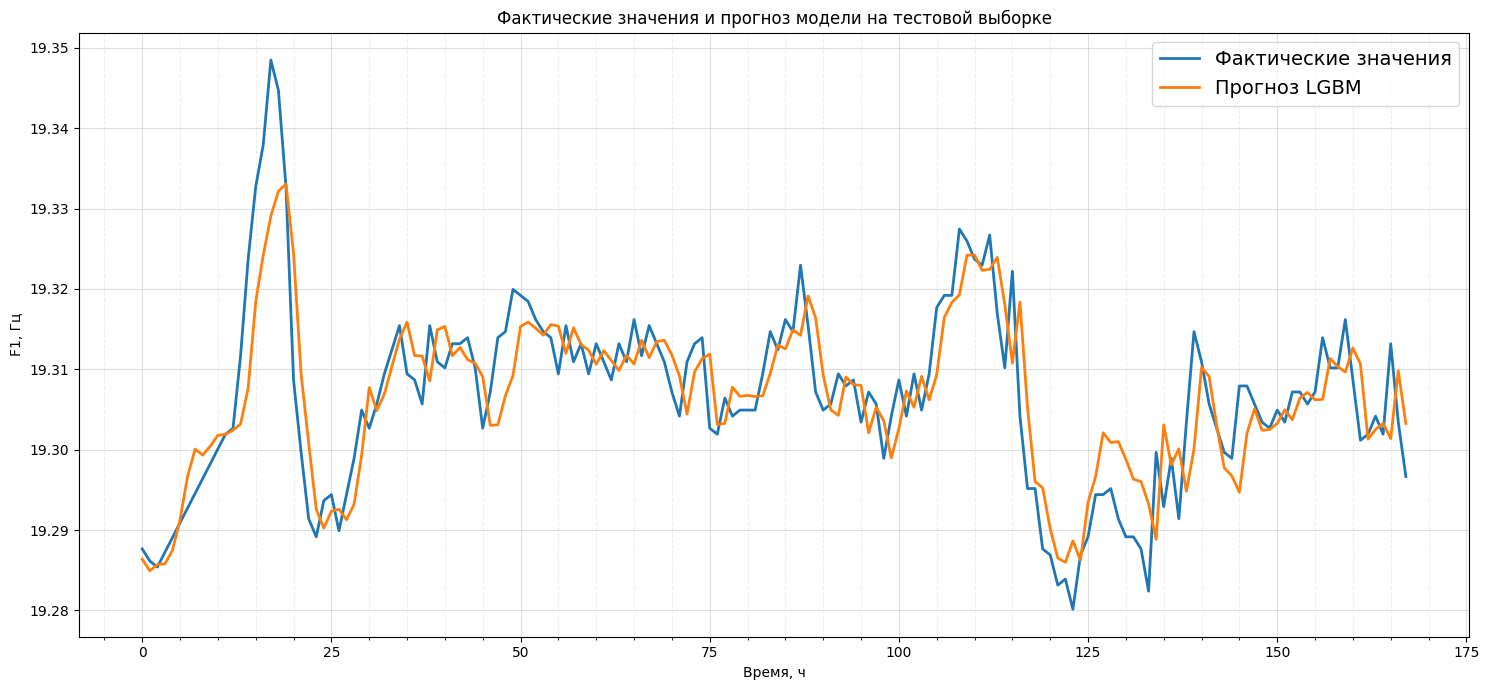

In [34]:
x = np.arange(len(test['y'].values))

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(x, test['y'].values, label="Фактические значения", linewidth=2)
ax.plot(x, preds[168:], label="Прогноз LGBM", linewidth=2)

ax.set_xlabel("Время, ч")
ax.set_ylabel("F1, Гц")
ax.set_title(f"Фактические значения и прогноз модели на тестовой выборке")

# Крупные тики — каждые 25 часов
ax.xaxis.set_major_locator(MultipleLocator(25))

# Мелкие тики — каждые 5 часов
ax.xaxis.set_minor_locator(MultipleLocator(5))

# Сетка
ax.grid(which="major", alpha=0.4)
ax.grid(which="minor", alpha=0.2, linestyle="--")

ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

Для наглядности построим столбчатый график, на котором показаны топ-5 наиболее значимых признаков

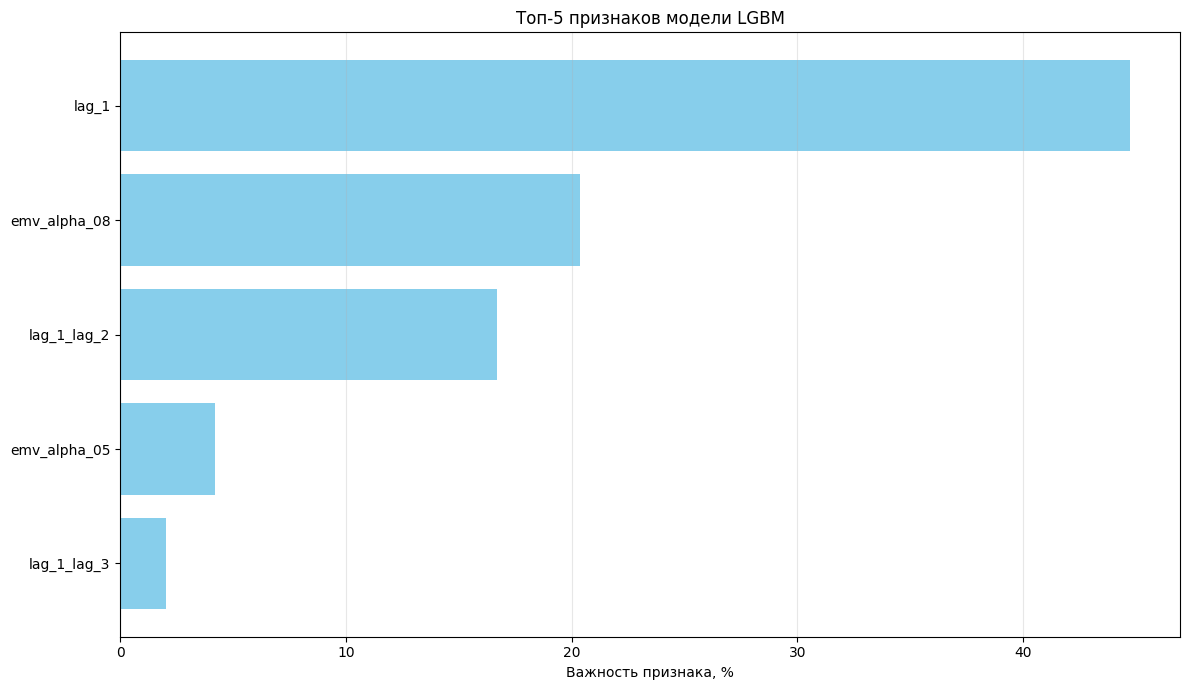

In [35]:
booster = model.booster_

feat_importances = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance': booster.feature_importance(importance_type='gain')
})

feat_importances['importance_pct'] = 100 * feat_importances['importance'] / feat_importances['importance'].sum()

feat_importances = feat_importances.sort_values(by='importance_pct', ascending=False)

top5 = feat_importances.head(5)

plt.figure(figsize=(12,7))
plt.barh(top5['feature'][::-1], top5['importance_pct'][::-1], color='skyblue')
plt.xlabel('Важность признака, %')
plt.title('Топ-5 признаков модели LGBM')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Наибольшую важность, как и ожидалось, показал признак, содержащий значение первого лага временного ряда, что в целом соответствует ожиданиям и подтверждает влияние недавних значений на предсказания модели. 

Реализуем теперь прототип мониторинга турбины на 24ч путем итеративного предсказания моделью нового значения.

100%|██████████| 24/24 [00:01<00:00, 19.05it/s]


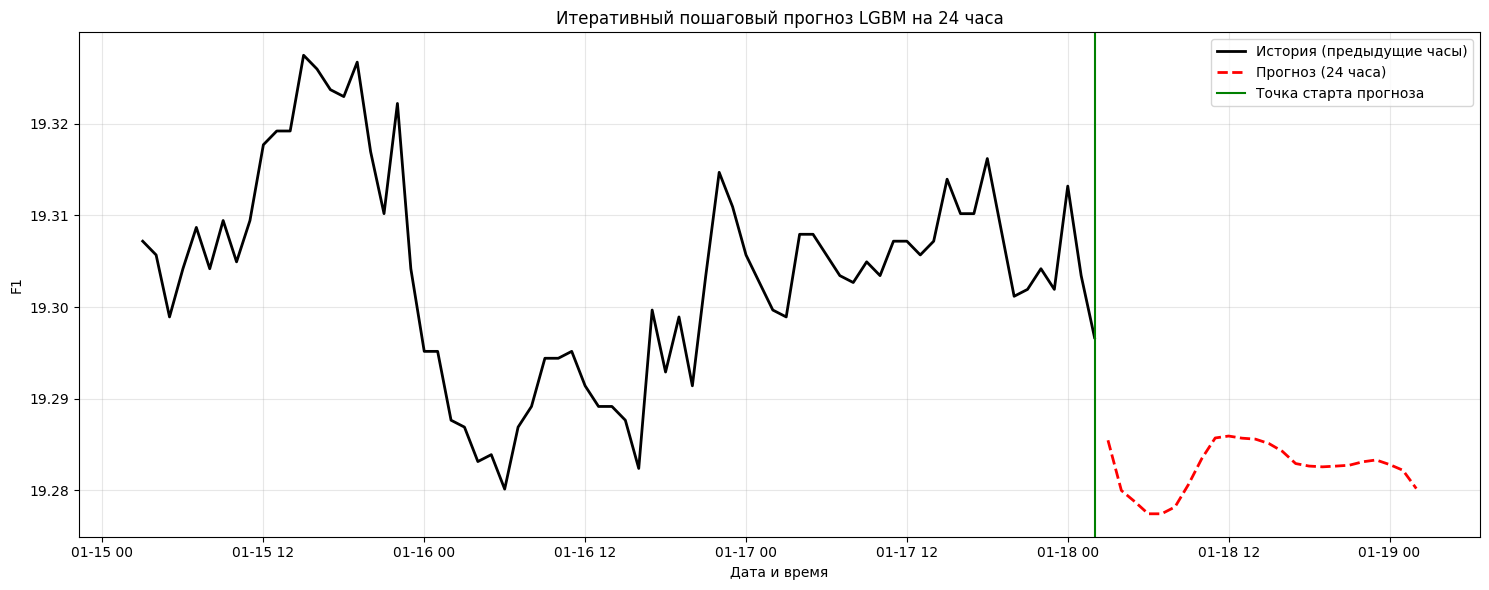

In [36]:
history_hours = 72  
horizon = 24    

# Берем последние history_hours часов для отображения истории
curr_history = df.tail(history_hours).copy().reset_index(drop=True)
forecasts = []

for h in tqdm(range(horizon)):
    next_date = curr_history['Date'].iloc[-1] + pd.Timedelta(hours=1)
    
    new_row = pd.DataFrame({
        'Date': [next_date],
        'y': [0.0], 
        'is_run': [1],
        'hour_off': [0],
        'hour_on': [curr_history['hour_on'].iloc[-1] + 1]
    })
    
    temp_history = pd.concat([curr_history, new_row], ignore_index=True)
    
    all_features = make_features(temp_history)
    X_input = all_features.reindex(columns=features).tail(1)
    
    y_pred = model.predict(X_input)[0]
    new_row['y'] = y_pred
    
    curr_history = pd.concat([curr_history, new_row], ignore_index=True).reset_index(drop=True)
    forecasts.append(y_pred)

plt.figure(figsize=(15,6))

plt.plot(curr_history['Date'].iloc[:history_hours], 
         curr_history['y'].iloc[:history_hours], 
         label='История (предыдущие часы)', color='black', linewidth=2)

plt.plot(curr_history['Date'].iloc[history_hours:history_hours+horizon], 
         forecasts, label='Прогноз (24 часа)', color='red', linestyle='--', linewidth=2)


plt.axvline(x=curr_history['Date'].iloc[history_hours-1], color='green', linestyle='-', label='Точка старта прогноза')

plt.xlabel('Дата и время')
plt.ylabel('F1')
plt.title('Итеративный пошаговый прогноз LGBM на 24 часа')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()